In [2]:
import numpy as np
import pandas as pd
import os
import wntr
import networkx as nx
import copy
import seaborn as sbn

## Generating file path names and reading the EPANET input file

In [3]:
# Getting path for the 'parent folder'
path_cwd = os.getcwd()
path_parent = os.path.abspath(os.path.join(path_cwd, os.pardir))

In [4]:
# Getting path for the input file
inputfiles_folder_name = 'Input_files_EPANET'
filename = 'Hanoi_base_demand.inp'
path_file = os.path.join(path_parent,inputfiles_folder_name,filename)

In [5]:
# Reading the input file into EPANET
inp_file = path_file
wn = wntr.network.WaterNetworkModel(inp_file)
wn1 = wntr.network.WaterNetworkModel(inp_file)

## Extracting base demands and reservoir head from the inp file

In [6]:
# store no of nodes and links
num_nodes = len(wn1.node_name_list)
num_links = len(wn1.link_name_list)

In [7]:
# create array that contains the base reservoir head and demand at nodes
base_demands = np.zeros((num_nodes))
base_demands[0]= wn1.get_node(1).head_timeseries.base_value
for i in range(1,num_nodes):
    base_demands[i] = wn1.get_node(i+1).demand_timeseries_list[0].base_value

In [8]:
#check
print(base_demands)

[2.000e+02 2.472e-01 2.361e-01 3.611e-02 2.014e-01 2.792e-01 3.750e-01 1.528e-01 1.458e-01 1.458e-01 1.389e-01 1.556e-01 2.611e-01 1.708e-01 7.778e-02 8.611e-02 2.403e-01 3.736e-01 1.667e-02 3.542e-01 2.583e-01 1.347e-01 2.903e-01 2.278e-01 4.722e-02 2.500e-01 1.028e-01 8.056e-02 1.000e-01
 1.000e-01 2.917e-02 2.236e-01]


## Creating co variance matrices
* Function to create a cov mat given the inputs

In [9]:
# define standard deviation matrix
std_dev = base_demands*0.2
std_dev[0] = base_demands[0]*0.05

In [10]:
#check
std_dev

array([1.000e+01, 4.944e-02, 4.722e-02, 7.222e-03, 4.028e-02, 5.583e-02, 7.500e-02, 3.056e-02, 2.917e-02, 2.917e-02, 2.778e-02, 3.111e-02, 5.222e-02, 3.417e-02, 1.556e-02, 1.722e-02, 4.806e-02, 7.472e-02, 3.334e-03, 7.083e-02, 5.167e-02, 2.694e-02, 5.806e-02, 4.556e-02, 9.444e-03, 5.000e-02,
       2.056e-02, 1.611e-02, 2.000e-02, 2.000e-02, 5.834e-03, 4.472e-02])

In [11]:
# function to create a covariance matrix 
def cov_mat_fixed(corr_demands,corr_reservoir_nodes):
    
    N = num_nodes
    
    mat_corr = np.zeros((N,N)) # initializing matrix

    mat = np.full((N-1,N-1),corr_demands) # step 1 for a symmetric matrix of n-1 by n-1
    mat_symm = (mat + mat.T)/2           # step 2

    diag = np.ones(N)   # setting up the diagonal matrix, variance of nodal demands
    np.fill_diagonal(mat_symm,diag)    
    mat_corr[1:,1:] = mat_symm

    mat_corr[0,0] = 1          # element (0,0) which is variance of resevoir head

    top = np.full((N-1),corr_reservoir_nodes) # covariance between reservoir head and nodal demands
    mat_corr[0,1:]=top
    mat_corr[1:,0]=top
    
    Diag = np.diag(std_dev)
    cov_mat = Diag * mat_corr * Diag
    
    return cov_mat

In [12]:
#Covmat for all experiments
covmat_base = cov_mat_fixed(0.6,0.0)

In [13]:
# Column names for the dataframe that will store results. Note that the Reservoir Demand and Head comes after all
# other nodes. Naming is done accordingly.

col_names=['Demand'+str(i) for i in range(2,33)]+\
          ['Demand_Reservoir']+\
          ['Node_head'+str(i) for i in range(2,33)]+\
          ['Res_Head']+\
          ['Link_flow'+str(i) for i in range(1,35)]

In [14]:
# check
# total columns = 32 demands + 32 heads + 34 flows
len(col_names)

98

In [15]:
def data_generation(train_samples,cov_mat,nodes_data):
      
    #getting samples 
    train_data_raw = np.random.multivariate_normal(nodes_data,cov_mat,train_samples)   
    
    #removing samples with negative values    
    train_data_raw_positive = train_data_raw[train_data_raw.min(axis=1)>=0,:]   
    
    #creating numpy arrays to store EPANET simulation output  
    train_samples_positive = train_data_raw_positive.shape[0]  
    data_out_demand = np.zeros((train_samples_positive,num_nodes))
    data_out_head = np.zeros((train_samples_positive,num_nodes))
    data_out_flow = np.zeros((train_samples_positive,num_links))   
    
    # loop to simulation to generate heads and flowrates
    for i in range(train_samples_positive):
        
        # updating reservoir head in the epanet input 
        wn.get_node(1).head_timeseries.base_value = train_data_raw_positive[i,0]
        
        # updating nodal demand for all nodes in the epanet input 
        j=1
        for n in wn.nodes.junction_names:            
            wn.get_node(n).demand_timeseries_list[0].base_value = train_data_raw_positive[i,j]            
            j=j+1
  
        # running epanet simulator
        sim = wntr.sim.EpanetSimulator(wn)
        
        # storing simulation results in 3 matrices
        results = sim.run_sim()
        data_out_demand[i] = np.array(results.node['demand'])
        data_out_head[i] = np.array(results.node['head'])
        data_out_flow[i] = np.array(results.link['flowrate'])
    
    # joining the above 3 matrices
    data_out_all = np.hstack((data_out_demand,data_out_head,data_out_flow))
    
    # dropping the results where any of the nodal pressure head value is negative
    data_out_all_positive = data_out_all[data_out_all[:,num_nodes:2*num_nodes].min(axis=1)>=0,:]
    
    return pd.DataFrame(columns=col_names,data=data_out_all_positive, index= None)

## Creating output sets for training and testing

In [15]:
# This dataset can be used for training the regression model
data_train_1 = data_generation(10000,covmat_base,base_demands)

In [17]:
# This dataset can be used for training the classification model 
data_train_2 = data_generation(10000,covmat_base,base_demands)

In [19]:
# This dataset can be used for testing the classification model
data_test = data_generation(10000,covmat_base,base_demands)

In [21]:
# This dataset can be used for generating leak scenarios
data_leak_gen = data_generation(10000,covmat_base,base_demands)

In [23]:
# check sizes
print(data_train_1.shape, data_train_2.shape, data_test.shape,data_leak_gen.shape)

(10000, 98) (10000, 98) (10000, 98) (10000, 98)


## Saving the output sets as csv datafiles to a folder named 'Data_files'. The datafiles are named while saving

In [24]:
# Output folder name defined
datafiles_folder_name = 'Data_files'

# Output file names defined
datafile_train1 = 'data_base_demand_train_1.csv'
datafile_train2 = 'data_base_demand_train_2.csv'
datafile_test = 'data_base_demand_test.csv'
datafile_leakgen = 'data_base_demand_leakgen.csv'

# Creating file paths. Note that 'path_parent' has been defined earlier
path_data_file_train1 = os.path.join(path_parent,datafiles_folder_name,datafile_train1)
path_data_file_train2 = os.path.join(path_parent,datafiles_folder_name,datafile_train2)
path_data_file_test = os.path.join(path_parent,datafiles_folder_name,datafile_test)
path_data_file_leakgen = os.path.join(path_parent,datafiles_folder_name,datafile_leakgen)

# Creating the 'Data_files' folder
os.makedirs(os.path.dirname(path_data_file_train1), exist_ok=True)

# Saving the output datasets as csv files whose paths have been defined above
data_train_1.to_csv(path_data_file_train1, index=None)
data_train_2.to_csv(path_data_file_train2, index=None)
data_test.to_csv(path_data_file_test, index=None)
data_leak_gen.to_csv(path_data_file_leakgen, index=None)

In [16]:
# This dataset can be used for training the classification model 
data_train_3 = data_generation(10000,covmat_base,base_demands)

In [17]:
# Output folder name defined
datafiles_folder_name = 'Data_files'

# Output file names defined
datafile_train3 = 'data_base_demand_train_3.csv'

# Creating file paths. Note that 'path_parent' has been defined earlier
path_data_file_train3 = os.path.join(path_parent,datafiles_folder_name,datafile_train3)

# Saving the output datasets as csv files whose paths have been defined above
data_train_3.to_csv(path_data_file_train3, index=None)

## End of notebook

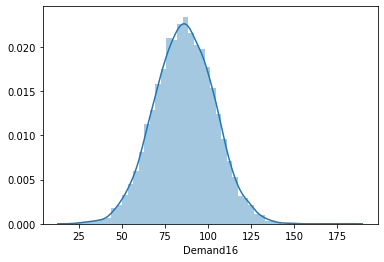

In [25]:
sbn.distplot(data_train_1.Demand16*1000)

In [26]:
np.std(data_train_1.Demand16*1000)

17.38683990195077

In [27]:
np.std(data_train_1.Demand2*1000)

48.82610487298087

In [28]:
np.mean(data_train_1.Demand16*1000)

86.20773371290416

In [29]:
np.mean(data_train_1.Res_Head)

199.90356206665038

In [30]:
np.std(data_train_1.Res_Head)

10.084802371592689